# AI in Games, _Reinforcement Learning_<br>Assignment 2, Report-related functions

## Preparing the context
The following are the necessary preparations and imports needed to run and test the main code of this document in the intended context. Mounting directory & setting present working directory...

In [76]:
# Mounting the Google Drive folder (run if necessary):
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
# Saving the present working directory's path:
# NOTE: Change `pwd` based on your own Google Drive organisation
pwd = "./drive/MyDrive/ColabNotebooks/AIG-Labs/AIG-Assignment2/"

Mounted at /content/drive/


To install module `import_ipynb` to enable importing Jupyter Notebooks as modules...

`!pip install import_ipynb`

Importing the code in notebook `Q1_environment.ipynb`...




In [77]:
import import_ipynb
N = import_ipynb.NotebookLoader(path=[pwd])
N.load_module("Q1_environment")
N.load_module("Q2_tabularModelBasedMethods")
N.load_module("Q3_tabularModelFreeMethods")
N.load_module("Q4_nonTabularModelFreeMethods")
N.load_module("Q5_deepReinforcementLearning")
from Q1_environment import *
from Q2_tabularModelBasedMethods import *
from Q3_tabularModelFreeMethods import *
from Q4_nonTabularModelFreeMethods import *
from Q5_deepReinforcementLearning import *

importing Jupyter notebook from ./drive/MyDrive/ColabNotebooks/AIG-Labs/AIG-Assignment2/Q1_environment.ipynb
importing Jupyter notebook from ./drive/MyDrive/ColabNotebooks/AIG-Labs/AIG-Assignment2/Q2_tabularModelBasedMethods.ipynb
importing Jupyter notebook from ./drive/MyDrive/ColabNotebooks/AIG-Labs/AIG-Assignment2/Q3_tabularModelFreeMethods.ipynb
importing Jupyter notebook from ./drive/MyDrive/ColabNotebooks/AIG-Labs/AIG-Assignment2/Q4_nonTabularModelFreeMethods.ipynb
importing Jupyter notebook from ./drive/MyDrive/ColabNotebooks/AIG-Labs/AIG-Assignment2/Q5_deepReinforcementLearning.ipynb


Other necessary imports...

In [316]:
import os
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from tabulate import tabulate
import warnings

## Global variables

In [50]:
# Setting pseudorandom number generator seed:
SEED = 0
# Setting discount factor as 0.9 (as instructed):
GAMMA = 0.9
# An arbitrarily large integer (practically infinity):
HUGE = 10**100

## Report Question 1
How many iterations did policy iteration require before returning an optimal policy for the big frozen lake? How many iterations did value iteration require? [2.5/100]

In [51]:
env = FrozenLake(lake['big'], 0.1, np.array(lake['big']).size, SEED)

# Running the functions:
PI = policy_iteration(env, GAMMA, theta=0, max_iterations=HUGE)
VI = value_iteration(env, GAMMA, theta=0, max_iterations=HUGE)
# NOTE 1: We have set an arbitrarily large number of max iterations
# NOTE 2: We have set margin of error as zero to look for full convergence
labels = ('policy iteration', 'value iteration')

# Displaying results:
# NOTE: Full results shown to show the policy is indeed optimal or near-optimal
displayResults((PI, VI), labels, env, theta=0)



AGENT PERFORMANCE AFTER POLICY ITERATION

Lake:
[['&' '.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '.' '.' '.']
 ['.' '.' '.' '#' '.' '.' '.' '.']
 ['.' '.' '.' '.' '.' '#' '.' '.']
 ['.' '.' '.' '#' '.' '.' '.' '.']
 ['.' '#' '#' '.' '.' '.' '#' '.']
 ['.' '#' '.' '.' '#' '.' '#' '.']
 ['.' '.' '.' '#' '.' '.' '.' '$']]
Policy:
[['>' '_' '_' '>' '_' '_' '_' '_']
 ['>' '>' '>' '>' '>' '>' '_' '_']
 ['>' '_' '_' '^' '>' '>' '_' '_']
 ['>' '>' '>' '>' '_' '^' '>' '_']
 ['>' '^' '^' '^' '>' '>' '>' '_']
 ['^' '^' '^' '>' '>' '_' '^' '_']
 ['_' '^' '>' '^' '^' '_' '^' '_']
 ['>' '>' '^' '^' '>' '>' '>' '^']]
Value:
[[0.151 0.177 0.199 0.225 0.258 0.291 0.326 0.348]
 [0.176 0.203 0.228 0.257 0.296 0.333 0.375 0.408]
 [0.185 0.211 0.233 0.000 0.319 0.365 0.421 0.471]
 [0.206 0.237 0.268 0.303 0.357 0.000 0.473 0.542]
 [0.180 0.207 0.228 0.000 0.412 0.473 0.542 0.625]
 [0.157 0.000 0.000 0.398 0.469 0.541 0.000 0.721]
 [0.153 0.000 0.287 0.338 0.000 0.625 0.000 0.849]
 [0.179 0.211 0.

## Report Question 2
For each model-free reinforcement learning algorithm (SARSA control, Q-learning control, linear SARSA control, linear Q-learning control, deep Q-network learning), store the return (sum of discounted rewards) obtained during each episode of interaction with the small frozen lake. For each of these algorithms, include a plot that shows the episode number on the x-axis and a moving average of these values on the y-axis. Use a moving average window of length 20. [10/100]
<br><br>**Hint**:

```
np.convolve(return_sarray, np.ones(20)/20, mode='valid'}
```

### CODE CREDIT:
This section's code is based on the work of Malo Hamon.<br>**Repository link**: https://github.com/nocommentcode/ecs7002_assignment_2/tree/main


### Environment wrapper to help track episodic rewards

In [97]:
class EpisodicWrapper:
    def __init__(self, env):
        self.env = env
        self.n_actions = self.env.n_actions

        # If `env` is wrapped, `self.n_states` may not be directly defined:
        try: self.n_states = self.env.n_states
        except: self.n_states = self.env.env.n_states

        # In case `env` is a `LinearWrapper` object:
        if isinstance(env, LinearWrapper):
            self.n_features = self.env.n_features

        # In case `env` is a `FrozenLakeImageWrapper` object:
        if isinstance(env, FrozenLakeImageWrapper):
            self.state_shape = self.env.state_shape

        self.curEpisodeRewards = []
        self.prevEpisodesRewards = []

    #===============================================

    # Resetting environment & moving to the next episode:

    def reset(self):
        # Storing the list of current rewards:
        if self.curEpisodeRewards != []:
            self.prevEpisodesRewards.append(self.curEpisodeRewards)
        # Resetting the current rewards list:
        self.curEpisodeRewards = []

        return self.env.reset()

    #================================================

    # Taking a step in environment & storing reward for current episode:

    def step(self, action):
        # Obtaining next state & observed reward:
        state, reward, done = self.env.step(action)
        # Storing the observed reward:
        self.curEpisodeRewards.append(reward)

        return state, reward, done

    #================================================

    # Clearing all stored values:

    def clear_storage(self):
        self.curEpisodeRewards = []
        self.prevEpisodesRewards = []

### Function to plot moving averages

In [98]:
def PLOT(returns, title, window, ax, label=None):
    '''
    PURPOSE:
    Plot the moving averages of the episode-wise returns.

    NOTE ON THE ARGUMENTS:
    - returns: An array of arrays, wherein
        - Row number ==> Method used
        - Column number ==> Episode
        - Each cell value contains reward for given method & episode
        - Each row contains episode-wise rewards for given method
    - title: Title of the plot (generally the name of the method used)
    - window: Size of the moving average window
    - ax: The `matplotlib.pyplot.axes.Axes` object in which plot must be done
    '''

    # Array of episodes for at which moving averages are calculated:
    episodes = np.arange(window-1, len(returns))
    '''
    NOTE: We start with `window-1`, since we cannot calculate the moving
    average with the required window size for any previous episodes (note that
    episode indexing starts at 0, so `window-1` is the index of the
    `window`-th episode).
    '''
    # Computing the moving averages:
    moving_average = np.convolve(returns, np.ones(window), mode='valid')/window
    ax.plot(episodes, moving_average, label=label)

    ax.set_title(title)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Moving Average')
    if label != None: ax.legend()

#### DEMO: `numpy.convolve`
Given two arrays $A$ and $B$ of the same size, the discrete convolution operation is defined as:

$(A * B)_t = \sum_{m=-\infty}^{\infty} A[x] B[t-x]$

**NOTE**: When the indices are out of bounds, consider the term as simply $0$.

---

Convolution is commutative, so: $(A * B)_t = (B * A)_t$

---

If $A$ and $B$ are not the same size but instead, say, $B$ is smaller than $A$, then `np.convolve` (with `mode='valid'`) produces an array containing multiple convolutions, wherein each convolution is that of a $B$-sized slice of $A$ and $B$ (the slices are taken in order, with the first slice being from index $0$ to $|B|-1$, the second slice being from index $1$ to $|B|$, etc.).

In [61]:
print('SAME-SIZED ARRAYS')
X = np.array([1, 2, 3, 4])
Y = np.array([1, -2, 3, -4])
Z = np.convolve(X, Y, mode='valid')

print(f'X = {list(X)}\nY = {list(Y)}')
print(f'Z = {list(Z)}')

print('------------------------------------')

print('DIFFERENTLY-SIZED ARRAYS')
X = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
Y = np.array([2, -3])
Z = np.convolve(X, Y, mode='valid')

print(f'X = {list(X)}\nY = {list(Y)}')
print(f'Z = {list(Z)}')

print('------------------------------------')

print('CALCULATING MOVING AVERAGES OF X WITH WINDOW SIZE 2')
MA = np.convolve(X, np.array([1, 1]), mode='valid')/2
# ALTERNATIVE: `MA = np.convolve(X, np.array([1, 1])/2, mode='valid')`

print(f'X = {list(X)}')
print(f'Moving averages (window size 2): {list(MA)}')

print('\nSame as doing `np.convolve` of the following:')
print(f'X = {list(X)}\nY = {list(np.array([1, 1])/2)}')

SAME-SIZED ARRAYS
X = [1, 2, 3, 4]
Y = [1, -2, 3, -4]
Z = [0]
------------------------------------
DIFFERENTLY-SIZED ARRAYS
X = [1, 2, 3, 4, 5, 6, 7, 8, 9]
Y = [2, -3]
Z = [1, 0, -1, -2, -3, -4, -5, -6]
------------------------------------
CALCULATING MOVING AVERAGES OF X WITH WINDOW SIZE 2
X = [1, 2, 3, 4, 5, 6, 7, 8, 9]
Moving averages (window size 2): [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]

Same as doing `np.convolve` of the following:
X = [1, 2, 3, 4, 5, 6, 7, 8, 9]
Y = [0.5, 0.5]


### Obtaining episode-wise rewards for each RL method
Helper function to evaluate the discounted return for all the episodes given an episodic wrapper object...

In [150]:
# NOTE: We need to define this function since it will be reused often later
def discounted_returns(wenv, max_episodes):
  # Initialising the array of discounted returns per episode:
  returns = np.zeros(max_episodes)
  # Obtaining data for all episodes (all previous + current):
  allEpisodesRewards = wenv.prevEpisodesRewards + [wenv.curEpisodeRewards]

  # Discount returns summation loop:
  for j, episodeRewards in enumerate(allEpisodesRewards):
      for k, reward in enumerate(episodeRewards):
          returns[j] += GAMMA**k*reward
  return returns

Running the required functions & obtaining the required data...

In [63]:
# DEFINING THE ARGUMENTS

# Environments & environment wrappers:
env = FrozenLake(lake['small'], 0.1, np.array(lake['small']).size, SEED)
wenv_lin = LinearWrapper(env)
wenv_img = FrozenLakeImageWrapper(env)

# General arguments:
max_episodes = 2000
eta = 1 # Not used for deep Q-network
epsilon = 1

# Deep Q-network arguments:
learning_rate = 0.01
batch_size = 50
target_update_frequency = 1
buffer_size = 500
kernel_size = 4
conv_out_channels = 12
fc_out_features = 12
args_dqn = [learning_rate, batch_size, target_update_frequency]

#================================================

# WRAPPERS

# Episodic wrapper objects:
wenvs = [# Wrappers for tabular model-free methods:
         EpisodicWrapper(env), EpisodicWrapper(env),
         # Wrappers for non-tabular model-free methods
         EpisodicWrapper(wenv_lin), EpisodicWrapper(wenv_lin),
         # Wrapper for deep reinforcement learning:
         EpisodicWrapper(wenv_img)]

#================================================

# RUNNING THE FUNCTIONS

# 3.1. SARSA control:
sarsa(wenvs[0], max_episodes, eta, GAMMA, epsilon, SEED),
# 3.2. Q-learning
q_learning(wenvs[1], max_episodes, eta, GAMMA, epsilon, SEED),
# 4.1. SARSA with linear action-value approximation:
linear_sarsa(wenvs[2], max_episodes, eta, GAMMA, epsilon, SEED),
# 4.2. Q-learning with linear action-value approximation:
linear_q_learning(wenvs[3], max_episodes, eta, GAMMA, epsilon, SEED),
# 5. Deep Q-network learning:
deep_q_network_learning(wenvs[4], max_episodes, learning_rate, GAMMA, epsilon, batch_size, target_update_frequency, buffer_size, kernel_size, conv_out_channels, fc_out_features, SEED)

#================================================

# OBTAINING DISCOUNTED RETURNS
returns = []
'''
NOTE ON `returns`:
It is a list of arrays meant to contain the discounted returns for each episode,
and for each RL method used. Its structure is as follows:
- Row number (list element number) ==> Method used
- Column number (array element number) ==> Episode
- Each cell value contains reward for given method & episode
- Each list element (row) contains episode-wise rewards for given method
'''
for wenv in wenvs: returns.append(discounted_returns(wenv, max_episodes))

Plotting the moving averages of per-episode discounted returns...

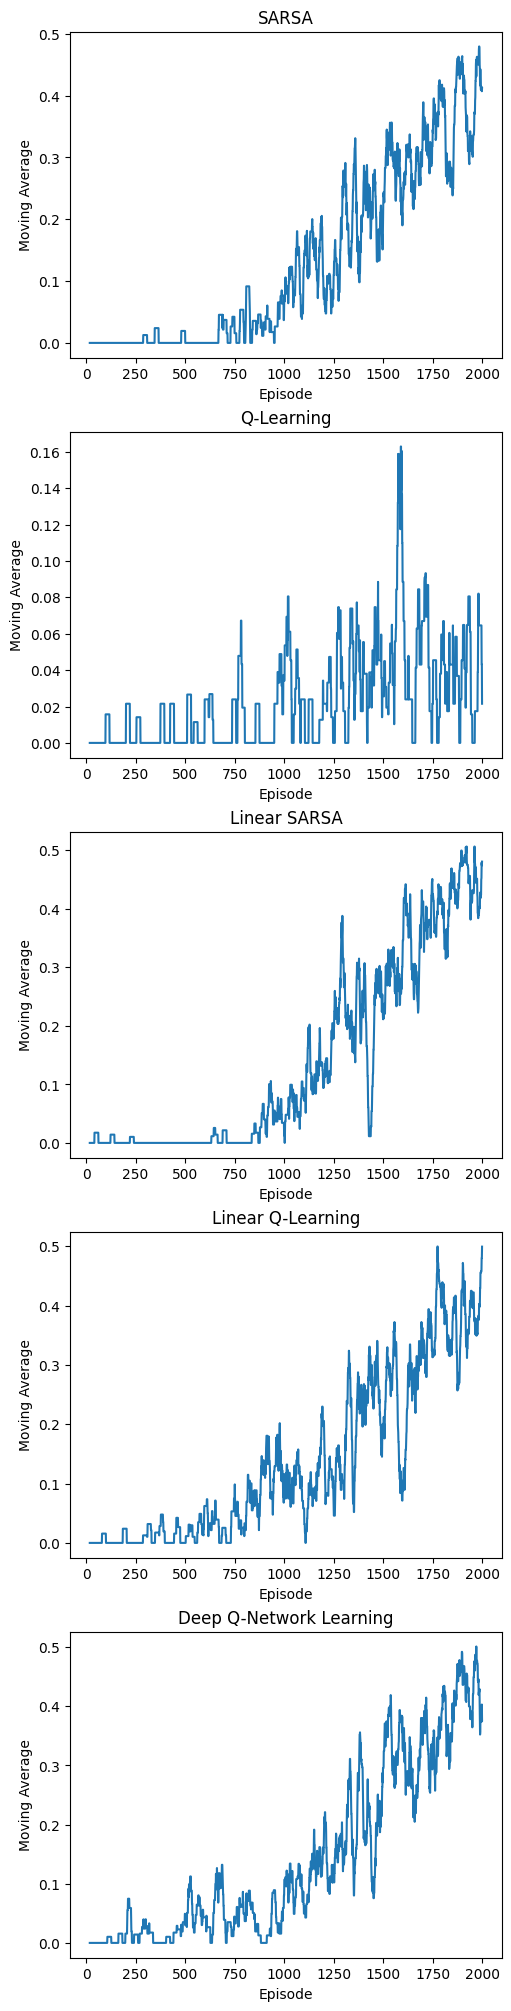


NOTE: Moving average is of per-episode discounted returns


In [64]:
# Titles for the plots:
titles = ('SARSA', 'Q-Learning',               # Tabular model-free methods
          'Linear SARSA', 'Linear Q-Learning', # Non-tabular model-free methods
          'Deep Q-Network Learning')           # Deep reinforcement learning

# Creating the plots:
fig, axs = plt.subplots(5, 1, constrained_layout=True, figsize=(5, 20))
for i in range(5): PLOT(returns[i], titles[i], 20, axs[i])
plt.show()

print('\nNOTE: Moving average is of per-episode discounted returns')

## Report Question 3
Try to minimize the number of episodes required to find an optimal policy for the small frozen lake by tweaking the parameters of SARSA control and Q-learning control (learning rate and exploration factor). Describe your results. Then try to find an optimal policy for the big frozen lake by tweaking the parameters of SARSA control and Q-learning control. Even if you fail, describe your results. [10/100]

---

### Setup
Some helper functions and global variables...

In [336]:
# Trivial function to switch elements safely:
def switch(a, b): return b, a

# Function to check if an array has NaN values:
def contains_nan(A):
    for a in A:
        if np.isnan(a): return True
    return False

Functions to search for LR and epsilon values at a certain level of precision...

In [392]:
# Searching for learning rate:
def lr_search(function, args, env, max_episodes, n_steps=None, precision=3):
    print('Searching for parameter: Learning Rate')
    args[0] = EpisodicWrapper(env)
    rangeMAX = 5
    lr = lrMAX = rewardMAX = lrFINAL = step = 1
    print('Current precision level:', end=' ')
    for i in range(precision):
        print(f'{i+1}/{precision}', end=', ')
        increment = 10**(-i)
        for j in range(0, rangeMAX, step):
            args[2] = lr
            args[0].clear_storage()
            args[0].env.resetRandomState()

            r = function(*args)
            if contains_nan(r[1]): continue
            reward = np.sum(discounted_returns(args[0], max_episodes))
            if reward > rewardMAX: lrMAX, rewardMAX = lr, reward
            lr += step*increment

        lrFINAL = lrMAX
        rangeMAX = 20
        if lrFINAL - 10**(-i) >= 0: lr, rangeMAX = lrFINAL - 10**(-i), 20
        else: lr, rangeMAX = lrFINAL, 10

        if n_steps != None: step = rangeMAX // n_steps
    print('Done!\n')
    return [lrFINAL, rewardMAX]

# Searching for exploration factor (epsilon):
def ef_search(function, args, env, max_episodes, n_steps=None, precision=3):
    print('Searching for parameter: Exploration Factor (epsilon)')
    args[0] = EpisodicWrapper(env)
    rangeMAX = ef = efMAX = efFINAL = step = 1
    rewardMAX = 0
    print('Current precision level:', end=' ')
    for i in range(precision):
        print(f'{i+1}/{precision}', end=', ')
        decrement = 10**(-i)
        for j in range(0, rangeMAX, step):
            args[4] = ef
            args[0].clear_storage()
            args[0].env.resetRandomState()

            r = function(*args)
            if contains_nan(r[1]): continue
            reward = np.sum(discounted_returns(args[0], max_episodes))
            if reward > rewardMAX: efMAX, rewardMAX = ef, reward
            ef -= step*decrement

        efFINAL = efMAX
        if efFINAL + 10**(-i) <= 1: e, rangeMAX = efFINAL + 10**(-i), 20
        else: ef, rangeMAX = efFINAL, 10
        if efFINAL == 0: rangeMAX = 10

        if n_steps != None: step = rangeMAX // n_steps
    print('Done!\n')
    return [efFINAL, rewardMAX]

Class to encapsulate all the required functions to handle tweaking of parameters...

In [433]:
class TweakingWrapper():
    def __init__(self, env, env_name):
        # Basic attributes:
        self.env = env
        self.env_name = env_name

        # Data storage:
        self.data = {'lr':[], 'ef':[]}
        self.vdata = {'lr':[], 'ef':[]}

        # Contants:
        self.methods = {'SARSA':sarsa, 'Q-Learning':q_learning}

    #================================================

    # Function to save search data:
    def save_data(self, category, data):
        if not os.path.isdir('data/'): os.mkdir('data/')
        np.save(f'data/{self.env_name} ({category})', data)

    #================================================

    # Function to perform search to tweak LR & epsilon:
    def search(self, max_episodes, n_steps=None, precision=3):
        self.data = {'lr':[], 'ef':[]}
        for method_name in self.methods:
            method = self.methods[method_name]
            print('------------------------------------')
            print(f'Searching for method: {method_name}')

            args = [None, max_episodes, None, GAMMA, 1, SEED]
            self.data['lr'].append(lr_search(method, args, env, max_episodes, n_steps, precision))
            args = [None, max_episodes, 1, GAMMA, None, SEED]
            self.data['ef'].append(ef_search(method, args, env, max_episodes, n_steps, precision))

        # Converting the data lists into NumPy arrays:
        for field in self.data: self.data[field] = np.array(self.data[field])

        # Saving the data:
        self.save_data('search', self.data)

    #================================================

    # Function to present search data as data frames:
    def present(self):
        methods = ['SARSA', 'Q-Learning']
        DF1 = DataFrame(data={'Method':methods,
                              'LR':self.data['lr'][:,0],
                              'Total discounted rewards':self.data['lr'][:,1]})
        DF2 = DataFrame(data={'Method':methods,
                              'EF':self.data['ef'][:,0],
                              'Total discounted rewards':self.data['ef'][:,1]})
        return DF1, DF2

    #================================================

    # Function to store data to help visualise the search results' goodness:
    def storeVisualisationData(self, max_episodes):
        # Learning rate & exploration obtained through search + new list:
        LR, EF, vdata = self.data['lr'][:,0], self.data['ef'][:,0], []
        # NOTE: vdata ==> Visualisation data

        print('NOTE: LR = Learning Rate, EF = Exploration Factor (epsilon)\n')

        # Data collection loop:
        for i, method_name in enumerate(self.methods):
            print('------------------------------------')
            print(f'Visualisation data for method: {method_name}')
            method = self.methods[method_name]

            # Values around the 'best' parameter value to compare with:
            LRs = [LR[i]/2, LR[i], 3*LR[i]/2] # For learning rate
            EFs = [EF[i]/2, EF[i], 1/2+EF[i]/2]   # For epsilon
            # NOTE: Some of the above may be duplicated; this is handled later

            # Lists to store data for each parameter:
            lrs, efs = [], []

            # Variables to help prevent redundant calculations:
            prev_lr, prev_ef = -1, -1

            # Data collection loop:
            for lr, ef in zip(LRs, EFs):
                wenv = EpisodicWrapper(self.env)

                # Collecting data for learning rate:
                if prev_lr != lr:
                    print(f'Collecting for parameter: LR = {lr:.3f}')
                    wenv.env.resetRandomState()
                    method(wenv, max_episodes, lr, GAMMA, 1, SEED)
                    lrs.append(list(discounted_returns(wenv, max_episodes)))
                    prev_lr = lr

                # Clearing `wenv` before collecting data for next parameter:
                wenv.clear_storage()

                # Collecting data for epsilon:
                if prev_ef != ef:
                    print(f'Collecting for parameter: EF = {ef:.3f}')
                    wenv.env.resetRandomState()
                    method(wenv, max_episodes, 1, GAMMA, ef, SEED)
                    efs.append(list(discounted_returns(wenv, max_episodes)))
                    prev_ef = ef
            print() # Adding some spacing
            vdata.append([lrs, efs])
        self.vdata = vdata

        # Saving the data:
        self.save_data('visualisation', {'vdata':self.vdata})

    #================================================

    def visualise(self, figsize=(5, 20)):
        LR, EF = self.data['lr'][:,0], self.data['ef'][:,0]

        fig, axs = plt.subplots(4, 1, constrained_layout=True, figsize=figsize)
        for i, method_name in enumerate(self.methods):
            LRs = [LR[i]/2, LR[i], 3*LR[i]/2]
            EFs = [EF[i]/2, EF[i], 1/2+EF[i]/2]

            # Title for the current set of plots:
            title = method_name + f' - {self.env_name}'

            # Plot loop for the current method:
            for j in range(2):
                # Labels for each parameter:

                # Number of parameter values to plot for:
                n = len(self.vdata[i][j])
                '''
                NOTE: Generally, we expect `n` to be 3, but in cases where the
                parameter value for a method was duplicated, `n` may be < 3.
                '''

                # Plot loop for the current parameter:
                for k in range(n):
                    label = [f'LR={LRs[k]:.3f}', f'$\epsilon$={EFs[k]:.3f}'][j]
                    PLOT(self.vdata[i][j][k], title, 20, axs[2*j+i], label)

### Tweaking parameters for small frozen lake
Setting up the object...

In [314]:
env = FrozenLake(lake['small'], 0.1, np.array(lake['small']).size, SEED)
small = TweakingWrapper(env=env, env_name='Small Lake')

Searching for best converging values of learning rate and exploration factor (epsilon)...

In [395]:
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore', category=RuntimeWarning)
    # NOTE: We don't need warnings since the issues are handled by the function
    small.search(max_episodes=2000)

------------------------------------
Searching for method: SARSA
Searching for parameter: Learning Rate
Current precision level: 1/3, 2/3, 3/3, Done!

Searching for parameter: Exploration Factor (epsilon)
Current precision level: 1/3, 2/3, 3/3, Done!

------------------------------------
Searching for method: Q-Learning
Searching for parameter: Learning Rate
Current precision level: 1/3, 2/3, 3/3, Done!

Searching for parameter: Exploration Factor (epsilon)
Current precision level: 1/3, 2/3, 3/3, Done!



#### Results

In [398]:
DF1, DF2 = small.present()
print(f'''TWEAKING PARAMETERS\nNOTE: When tweaking one, we set the other as 1\n
{tabulate(DF1, headers='keys', tablefmt='psql')}\n\n
{tabulate(DF2, headers='keys', tablefmt='psql')}''')

TWEAKING PARAMETERS
NOTE: When tweaking one, we set the other as 1

+----+------------+------+----------------------------+
|    | Method     |   LR |   Total discounted rewards |
|----+------------+------+----------------------------|
|  0 | SARSA      | 0.15 |                    307.772 |
|  1 | Q-Learning | 0.45 |                     46.543 |
+----+------------+------+----------------------------+


+----+------------+------+----------------------------+
|    | Method     |   EF |   Total discounted rewards |
|----+------------+------+----------------------------|
|  0 | SARSA      | 0.91 |                   284.581  |
|  1 | Q-Learning | 0.91 |                    38.2358 |
+----+------------+------+----------------------------+


#### Visualisation

Storing visualisation data...

In [402]:
small.storeVisualisationData(max_episodes=2000)

NOTE: LR = Learning Rate, EF = Exploration Factor (epsilon)

------------------------------------
Visualisation data for method: SARSA

------------------------------------
Visualisation data for method: Q-Learning



Visualising stored data...

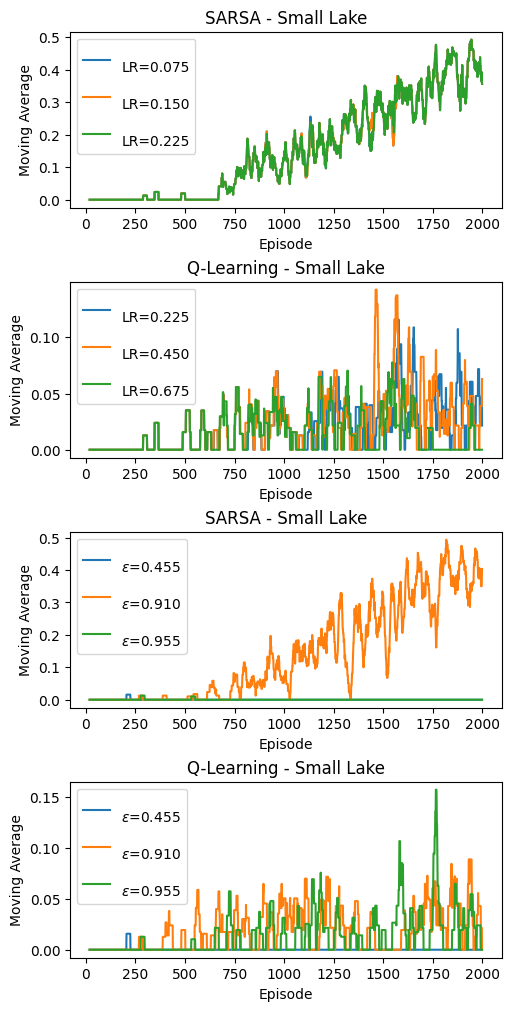

In [403]:
small.visualise(figsize=(5, 10))

### Tweaking parameters for big frozen lake
Setting up the object...

In [406]:
env = FrozenLake(lake['big'], 0.1, np.array(lake['big']).size, SEED)
big = TweakingWrapper(env=env, env_name='Big Lake')

Searching for best converging values of LR and epsilon...

In [407]:
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore', category=RuntimeWarning)
    # NOTE: We don't need warnings since the issues are handled by the function
    big.search(max_episodes=10000, n_steps=5)

------------------------------------
Searching for method: SARSA
Searching for parameter: Learning Rate
Current precision level: 1/3, 2/3, 3/3, Done!

Searching for parameter: Exploration Factor (epsilon)
Current precision level: 1/3, 2/3, 3/3, Done!

------------------------------------
Searching for method: Q-Learning
Searching for parameter: Learning Rate
Current precision level: 1/3, 2/3, 3/3, Done!

Searching for parameter: Exploration Factor (epsilon)
Current precision level: 1/3, 2/3, 3/3, Done!



#### Results

In [419]:
DF1, DF2 = big.present()
print(f'''TWEAKING PARAMETERS\nNOTE: When tweaking one, we set the other as 1\n
{tabulate(DF1, headers='keys', tablefmt='psql')}\n\n
{tabulate(DF2, headers='keys', tablefmt='psql')}''')

TWEAKING PARAMETERS
NOTE: When tweaking one, we set the other as 1

+----+------------+------+----------------------------+
|    | Method     |   LR |   Total discounted rewards |
|----+------------+------+----------------------------|
|  0 | SARSA      | 1    |                      1     |
|  1 | Q-Learning | 0.34 |                    425.032 |
+----+------------+------+----------------------------+


+----+------------+------+----------------------------+
|    | Method     |   EF |   Total discounted rewards |
|----+------------+------+----------------------------|
|  0 | SARSA      |    1 |                  0.0388744 |
|  1 | Q-Learning |    1 |                313.571     |
+----+------------+------+----------------------------+


#### Visualisation

Storing visualisation data...

In [432]:
big.storeVisualisationData(max_episodes=10000)

NOTE: LR = Learning Rate, EF = Exploration Factor (epsilon)

------------------------------------
Visualisation data for method: SARSA

------------------------------------
Visualisation data for method: Q-Learning


Visualising stored data...

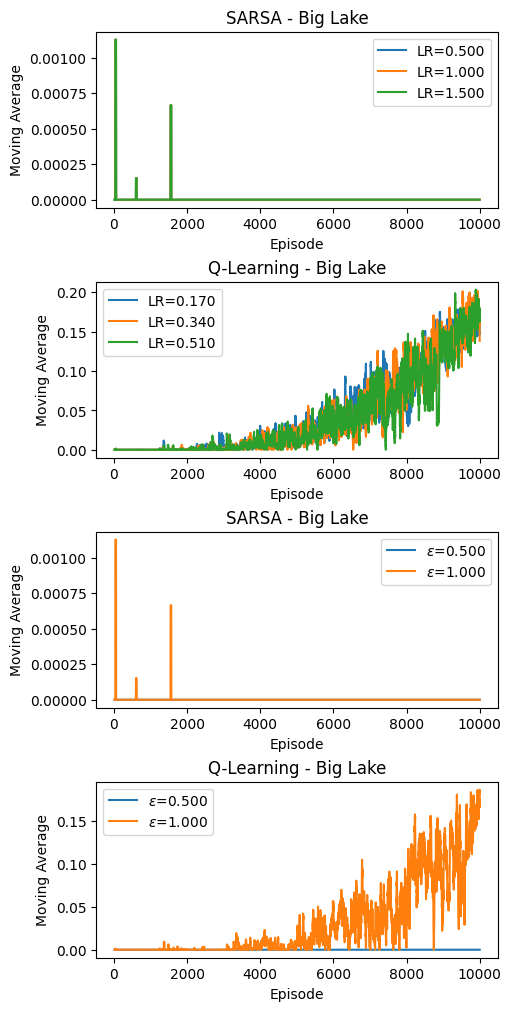

In [435]:
big.visualise(figsize=(5, 10))

## Report Question 4
In linear action-value function approximation, how can each element of the parameter vector $\theta$ be interpreted when each possible pair of state s and action a is represented by a different feature vector $\phi(s, a)$ where all elements except one are zero? Explain why the tabular model-free reinforcement learning algorithms that you implemented are a special case of the non-tabular model-free reinforcement learning algorithms that you implemented. [2.5/100]

## Report Question 5
During deep Q-network training, why is it necessary to act according to an $\epsilon$-greedy policy instead of a greedy policy (with respect to Q)? [2.5/100]

## Report Question 6
How do the authors of deep Q-network learning [Mnih et al., 2015] explain the need for a target Q-network in addition to an online Q-network? [2.5/100]